In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

# Lectura de datos

* La primer columna representa el label o etiqueta de letra al que corresponde el vector de la 1:

In [92]:
df = pd.read_csv('emnist_short.csv')

df.shape

(100, 785)

# Creación de subconjuntos
*
* 7x7
* 10x10
* 15x15

In [93]:
def reshape_img(row, dim):
    """
        Toma el vector de la imagen original (flatten) y lo convierte a una matriz de 28x28
        Usando cv2, se usa esa matriz de 28x28 para convertirla a dimXdim
        Luego, se rota 90 grados
    """
    original = row.values.reshape(28, 28).astype(np.uint8)
    resized = cv2.resize(original, (dim, dim), interpolation=cv2.INTER_AREA)
    resized = np.rot90(resized)
    return resized

aqui se cambia el número de letras

In [94]:
def create_subset(df, tamaño, finish_index):
    subset = df.iloc[0:finish_index+1, :]
    return pd.DataFrame({
        'label': subset.iloc[:, 0],
        'image': subset.iloc[:, 1:].apply(lambda row: reshape_img(row, tamaño), axis=1)
    })

finish_index = 13

df_7 = create_subset(df, 22, finish_index)
df_10 = create_subset(df, 24, finish_index)
df_15 = create_subset(df, 26, finish_index)


In [95]:
df_7.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [96]:
df_10.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [97]:
df_15.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


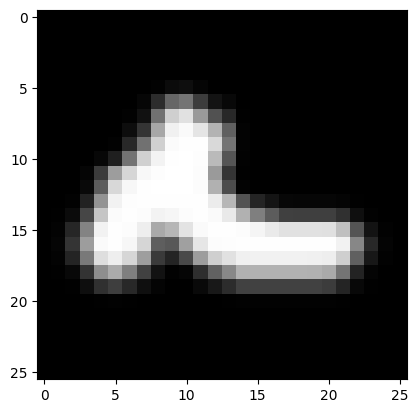

In [98]:
plt.imshow(df_15.iloc[0, 1], cmap='gray')
plt.show()

# Bipolarización de datos (-1, 1)

* Se evalúa cada pixel de la imagen y si es mayor a un thresehold se vuelve 1, de lo contrario -1

In [99]:
def make_bipolar(row, thereshold):
    return np.where(row < thereshold, -1, 1)

dfs = [df_7, df_10, df_15]
bin_dfs = []

for df in dfs:
    df_bin = pd.DataFrame({
        'label': df['label'],
        'image': df['image'].apply(make_bipolar, thereshold=40)
    })
    
    bin_dfs.append(df_bin)

dfb_7, dfb_10, dfb_15 = bin_dfs

In [100]:
dfb_15.head(1)

,label,image
0,45,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


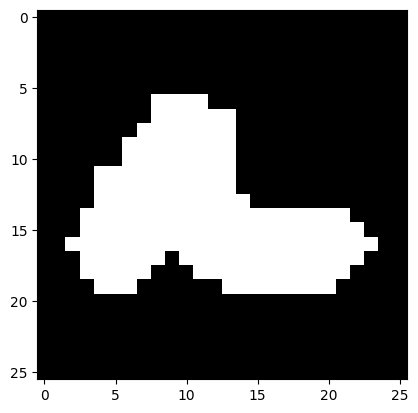

In [101]:
plt.imshow(dfb_15.iloc[0, 1], cmap='gray')
plt.show()

# 2. Red de Hopfield Sincrónica

* Se hacen los cálculos uno por uno

Se usarán los datos a partir del registro 10, de uno en uno para ver en donde comienza a fallar

In [102]:
def train_hopfield(patterns):
    n = patterns.shape[1]
    W = np.zeros((n, n))

    for pattern in patterns:
        W += np.outer(pattern, pattern)

    np.fill_diagonal(W, 0)
    
    return W

In [103]:
#weigths = []

for dfb in [dfb_7, dfb_10, dfb_15]:
    # Por cada df, obtenemos su matriz de pesos
    # train_hopfield recibe un arreglo de numpy
    # Este arreglo debe de estar aplanado y dado en una matriz bidimensional
    # Esto apra sacar el número de neuronas igual a las 
    # columnas totales de cada patrón
    dfb['flat'] = dfb['image'].apply(lambda x: np.array(x).flatten())

    #patterns = np.stack(dfb['flat'].to_numpy())
    #W = train_hopfield(patterns)

    #weigths.append(W)

#w7, w10, w15 = weigths

In [104]:
dfb_15

,label,image,flat
0,45,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,36,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,43,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,15,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,42,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
5,26,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
6,32,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
7,20,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
8,46,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9,43,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


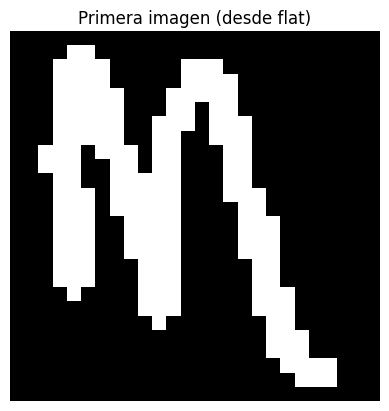

In [105]:
flat_vector = np.array(dfb_15.iloc[6]['flat'])  # Obtener el vector plano de la primera fila

# Calcular dimensión de la imagen (asumimos cuadrada)
dim = int(np.sqrt(len(flat_vector)))

# Convertir a matriz 2D
img = flat_vector.reshape((dim, dim))

# Mostrar imagen
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
plt.title("Primera imagen (desde flat)")
plt.axis('off')
plt.show()

In [106]:
def sign(x):
    return np.where(x >= 0, 1, -1)
    
def retrieve_hopfield(W, pattern, max_iter=100):

    for i in range(max_iter):
        updated = sign(W @ pattern)
        
        if np.array_equal(updated, pattern):
            break
        
        pattern = updated

    return pattern

# 3. Red Hebbiana Clásica

Se implementa una red auto-asociativa no recurrente

In [107]:
def classic_hebb(X):
    X_pinv = np.linalg.pinv(X)  
    W = X_pinv @ X

    return W

#classic_hebb(X)
#y_recuperado = x @ W

# 4. Experimentos de almacenamiento

In [108]:
def add_noise(pattern, noise_level):
    p = pattern.copy()
    n = len(p)

    num_flips = int(noise_level * n)
    flip_indices = np.random.choice(n, num_flips, replace=False)

    p[flip_indices] *= -1

    return p

In [109]:
def show_comparison(original_img, noisy_flat, recovered_flat, dim, n):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    titles = ["Original", "Con ruido", "Recuperado"]
    images = [
        np.array(original_img).reshape((dim, dim)),
        np.array(noisy_flat).reshape((dim, dim)),
        np.array(recovered_flat).reshape((dim, dim))
    ]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray", vmin=-1, vmax=1)
        ax.set_title(f'{title} {dim}x{dim} - {n}')
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def test_store(noise_perc=0.1, show_errors_only=True):
    patterns_to_store = np.arange(start=1, stop=6, step=1)
    dfs = [
        (dfb_7, '22x22')
        #,(dfb_10, '24x24'),
        #(dfb_15, '26x26')
    ]
    results = []

    for df, size_label in dfs:
        dim = int(size_label.split('x')[0])  # extraer el tamaño correcto

        for n in patterns_to_store:
            df_train = df.sample(n=n)
            patterns = np.stack(df_train['flat'].to_numpy())
            w = train_hopfield(patterns)

            success_count = 0
            for p in patterns:
                noisy_flat = add_noise(p, noise_level=noise_perc)
                recalled = retrieve_hopfield(w, noisy_flat)

                show_comparison(p, noisy_flat, recalled, dim, n)

                if np.array_equal(recalled, p):
                    success_count += 1
                #elif not show_errors_only:
                #    show_comparison(p, noisy_flat, recalled, dim=dim, n)
                #elif show_errors_only:
                #    show_comparison(p, noisy_flat, recalled, dim=dim, n)

            success_rate = success_count / n
            results.append({
                'image_size': size_label,
                'num_patterns': n,
                'success_rate': success_rate
            })

    results_df = pd.DataFrame(results)
    return results_df

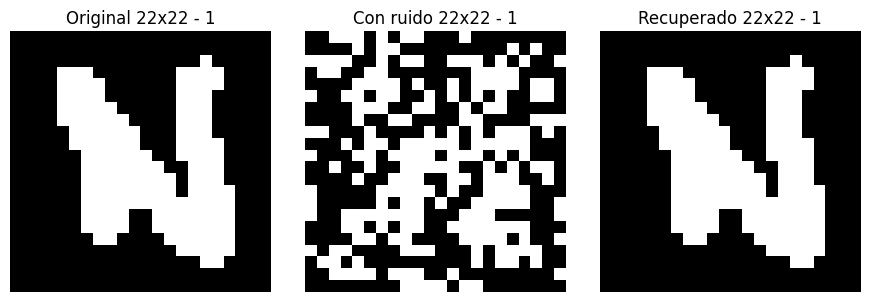

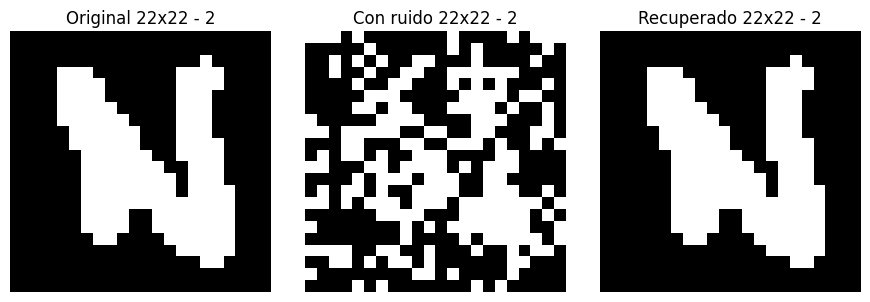

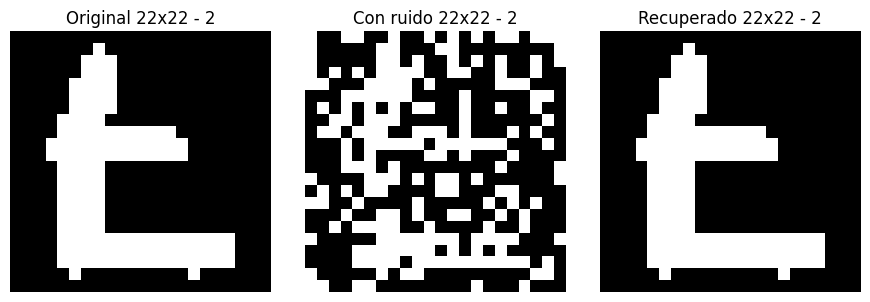

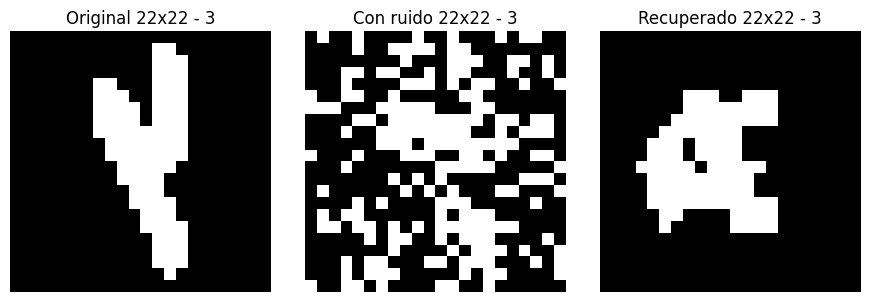

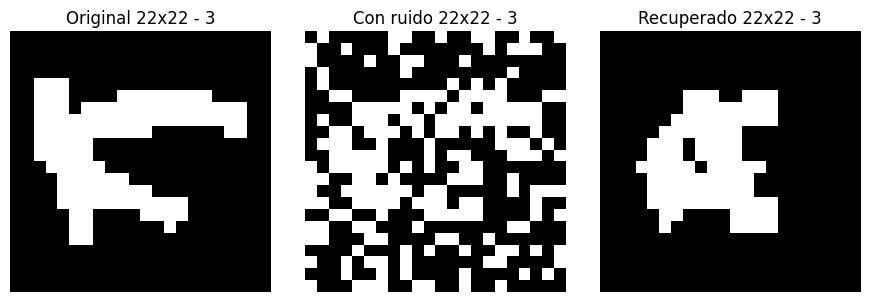

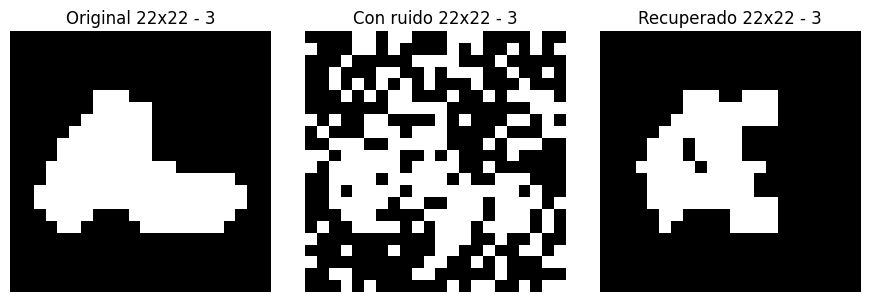

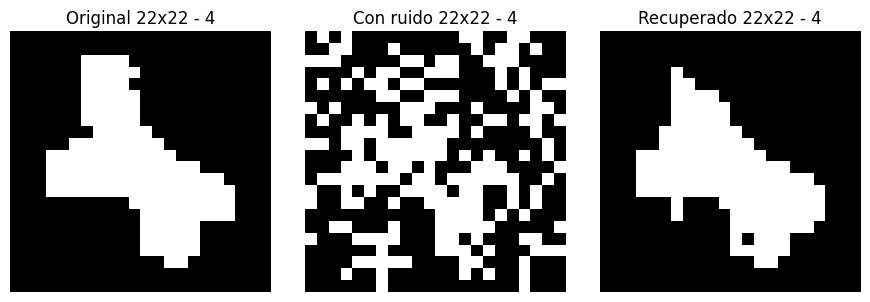

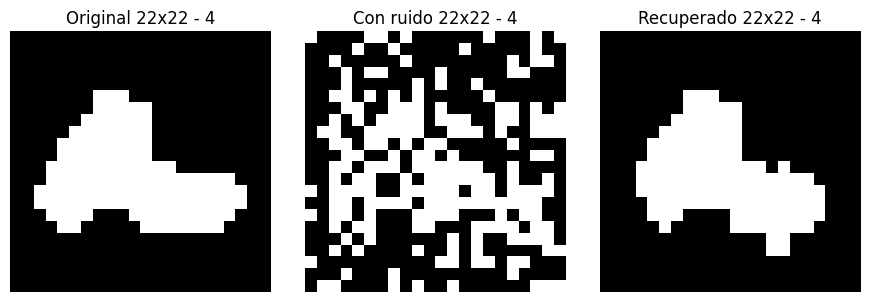

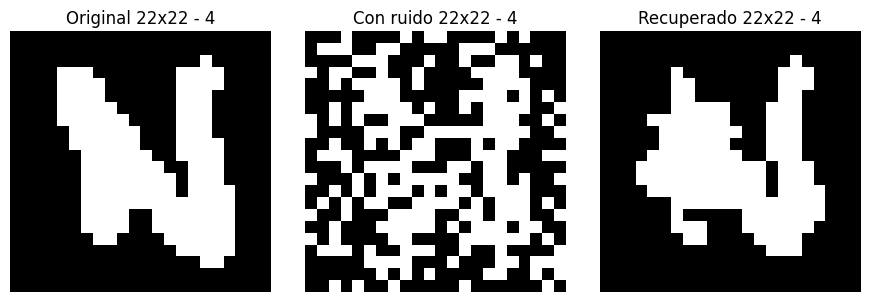

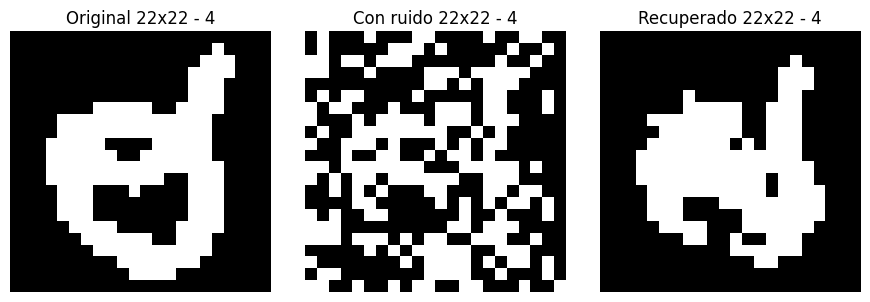

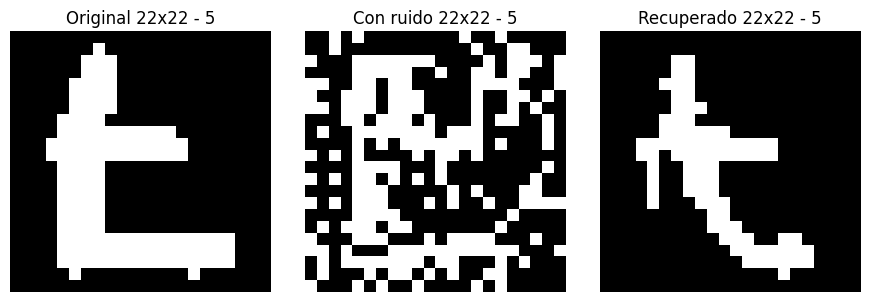

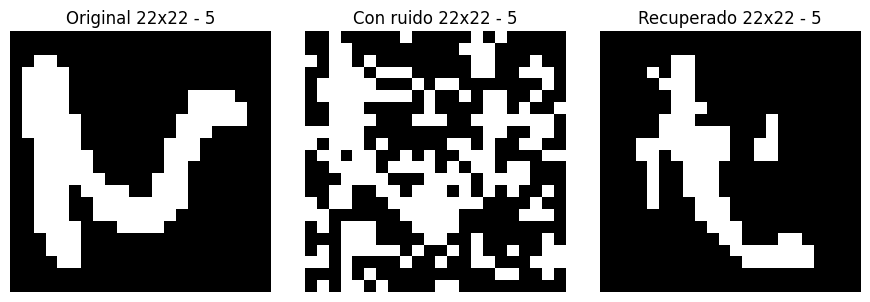

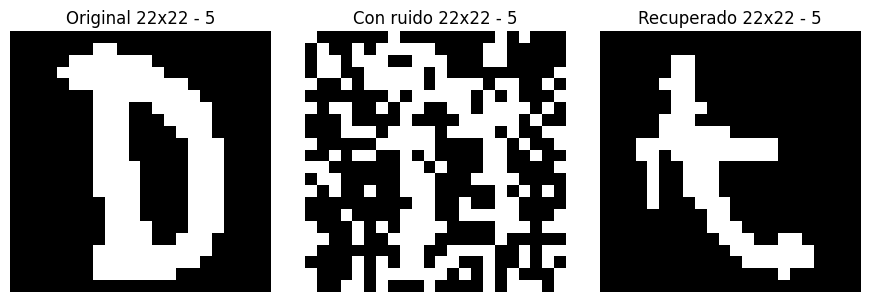

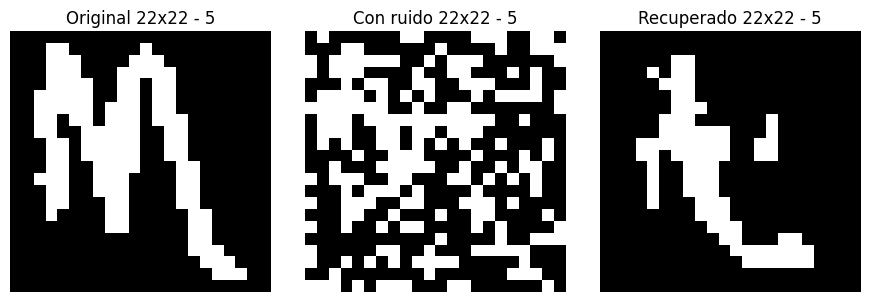

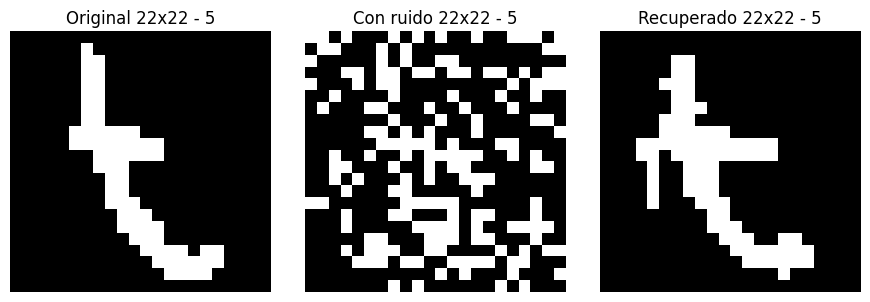

,image_size,num_patterns,success_rate
0,22x22,1,1.0
1,22x22,2,1.0
2,22x22,3,0.0
3,22x22,4,0.0
4,22x22,5,0.0


In [110]:
results_compare = test_store(0.3)

results_compare

# 5. Evaluación de tolerancia al ruido

# 6. Comparación de Hopfield vs Clásica

* Recuperación
* Almacenamiento
* Tolerancia al ruido

# 7. Análisis Estadístico

* Medidas estadísticas
* Gráfica de tasa de recuperación vs número de patrones almacenados y nivel de ruido

In [111]:
def show_comparison(original_img, noisy_flat, recovered_flat):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    titles = ["Original", "Con ruido", "Recuperado"]
    images = [
        np.array(original_img),
        np.array(noisy_flat).reshape((15,15)),
        np.array(recovered_flat).reshape((15,15))
    ]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray", vmin=-1, vmax=1)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

original_img = dfb_15.iloc[1, 1]
original_flat = np.array(dfb_15.iloc[1, 2])
noisy_flat = add_noise(original_flat, noise_level=0.1)
recovered_flat = retrieve_hopfield(w15, noisy_flat)

show_comparison(original_img, noisy_flat, recovered_flat)

NameError: name 'w15' is not defined